<a href="https://colab.research.google.com/github/StephenSheng1101/DMAsgmnt/blob/main/Model_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [26]:
df = pd.read_csv("dataset.csv")

In [27]:
def load_transport_data():
    tarball_path = Path("/content/dataset.csv")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        with tarfile.open(tarball_path) as transport_tarball:
            transport_tarball.extractall(path="datasets")
    return pd.read_csv(Path("/content/dataset.csv"))

transport = load_transport_data()
transport.head()

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,2013-07-02 19:54:00.000000232,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,2013-09-28 00:21:31.0000002,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,2013-06-16 03:18:00.000000150,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,2013-07-20 13:43:00.000000121,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,2013-11-05 22:57:17.0000003,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0


In [28]:
transport.describe()
transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175012 entries, 0 to 2175011
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ID              object 
 1   travel_fee      float64
 2   departure_time  object 
 3   departure_long  float64
 4   departure_lat   float64
 5   arrival_long    float64
 6   arrival_lat     float64
 7   occupancy       float64
dtypes: float64(6), object(2)
memory usage: 132.8+ MB


In [29]:
transport.isnull().sum()

ID                 0
travel_fee         0
departure_time     0
departure_long     0
departure_lat      0
arrival_long      34
arrival_lat       34
occupancy          1
dtype: int64

In [30]:
#handling missing value
transport["departure_long"].fillna(transport["departure_long"].mean(), inplace=True)
transport["departure_lat"].fillna(transport["departure_lat"].mean(), inplace=True)
transport["occupancy"].fillna(transport["occupancy"].mode()[0], inplace=True)
transport.drop(columns=['ID'], inplace=True)

# Drop rows with missing "departure_time","arrival_long" and "arrival_lat"
transport.dropna(subset=["departure_time", "arrival_long", "arrival_lat"],inplace = True)
transport.isnull().sum()

# Drop rows with a 0 value of occupancy
transport = transport.drop(transport[transport['occupancy'] <= 0].index)

In [31]:
transport.head()

,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0


In [32]:
# Convert departure_time to datetime
transport['departure_time'] = pd.to_datetime(transport['departure_time'])

# Extract features from departure_time
transport['hour_of_day'] = transport['departure_time'].dt.hour
transport['day_of_week'] = transport['departure_time'].dt.dayofweek

In [33]:
from sklearn.preprocessing import StandardScaler

data_numeric = transport.drop(columns=['departure_time'])

# Perform feature scaling using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_numeric)
scaled_data

array([[-0.51753093, -0.13925827,  0.11140278, ..., -0.51567607,
         0.83934523, -1.04212392],
       [-0.65623311, -0.14004065,  0.10915241, ..., -0.51567607,
        -2.06496605,  1.00247489],
       [ 0.82325685, -0.13798895,  0.11495856, ..., -0.51567607,
        -1.60639058,  1.5136246 ],
       ...,
       [-0.70246717, -0.14015306,  0.10945915, ...,  0.93823902,
         0.99220372, -0.01982451],
       [-0.60999905, -0.138026  ,  0.11370588, ..., -0.51567607,
         1.45077919,  1.00247489],
       [-0.10142438, -0.13938507,  0.11312753, ..., -0.51567607,
         1.14506221,  1.00247489]])

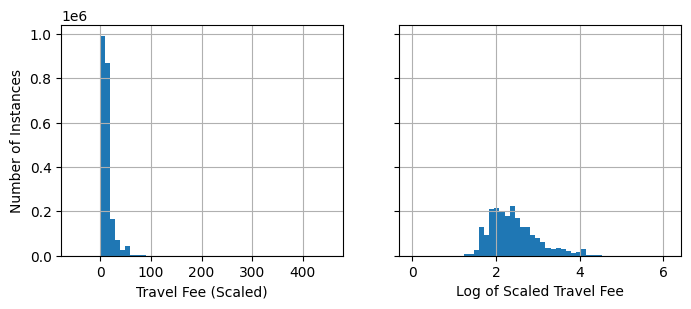

In [34]:
# Plot histogram of a scaled feature
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
transport["travel_fee"].hist(ax=axs[0], bins=50)
transport["travel_fee"].apply(np.log1p).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Travel Fee (Scaled)")
axs[1].set_xlabel("Log of Scaled Travel Fee")
axs[0].set_ylabel("Number of Instances")
plt.show()

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ['travel_fee', 'departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'hour_of_day', 'day_of_week','occupancy']

num_pipeline = make_pipeline(
    StandardScaler()  # Scale features
)
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    # Apply numeric pipeline to numeric attributes
])

In [36]:
transport_prepared = preprocessing.fit_transform(transport)
transport_prepared

array([[-0.51753093, -0.13925827,  0.11140278, ...,  0.83934523,
        -1.04212392, -0.51567607],
       [-0.65623311, -0.14004065,  0.10915241, ..., -2.06496605,
         1.00247489, -0.51567607],
       [ 0.82325685, -0.13798895,  0.11495856, ..., -1.60639058,
         1.5136246 , -0.51567607],
       ...,
       [-0.70246717, -0.14015306,  0.10945915, ...,  0.99220372,
        -0.01982451,  0.93823902],
       [-0.60999905, -0.138026  ,  0.11370588, ...,  1.45077919,
         1.00247489, -0.51567607],
       [-0.10142438, -0.13938507,  0.11312753, ...,  1.14506221,
         1.00247489, -0.51567607]])

In [37]:
preprocessing.get_feature_names_out()

array(['num__travel_fee', 'num__departure_long', 'num__departure_lat',
       'num__arrival_long', 'num__arrival_lat', 'num__hour_of_day',
       'num__day_of_week', 'num__occupancy'], dtype=object)

In [38]:
transport.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174960 entries, 0 to 2175011
Data columns (total 9 columns):
 #   Column          Dtype              
---  ------          -----              
 0   travel_fee      float64            
 1   departure_time  datetime64[ns, UTC]
 2   departure_long  float64            
 3   departure_lat   float64            
 4   arrival_long    float64            
 5   arrival_lat     float64            
 6   occupancy       float64            
 7   hour_of_day     int64              
 8   day_of_week     int64              
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 165.9 MB


In [39]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(transport.head(500000), test_size=0.2, random_state=42)

print("Length of train_set:", len(train_set))
print("Length of test_set:", len(test_set))

Length of train_set: 400000
Length of test_set: 100000


In [ ]:
# Import libraries

# Define features and target variables

# Initialize..

# Train the model

# Predict on the test set

# Evaluate the model

